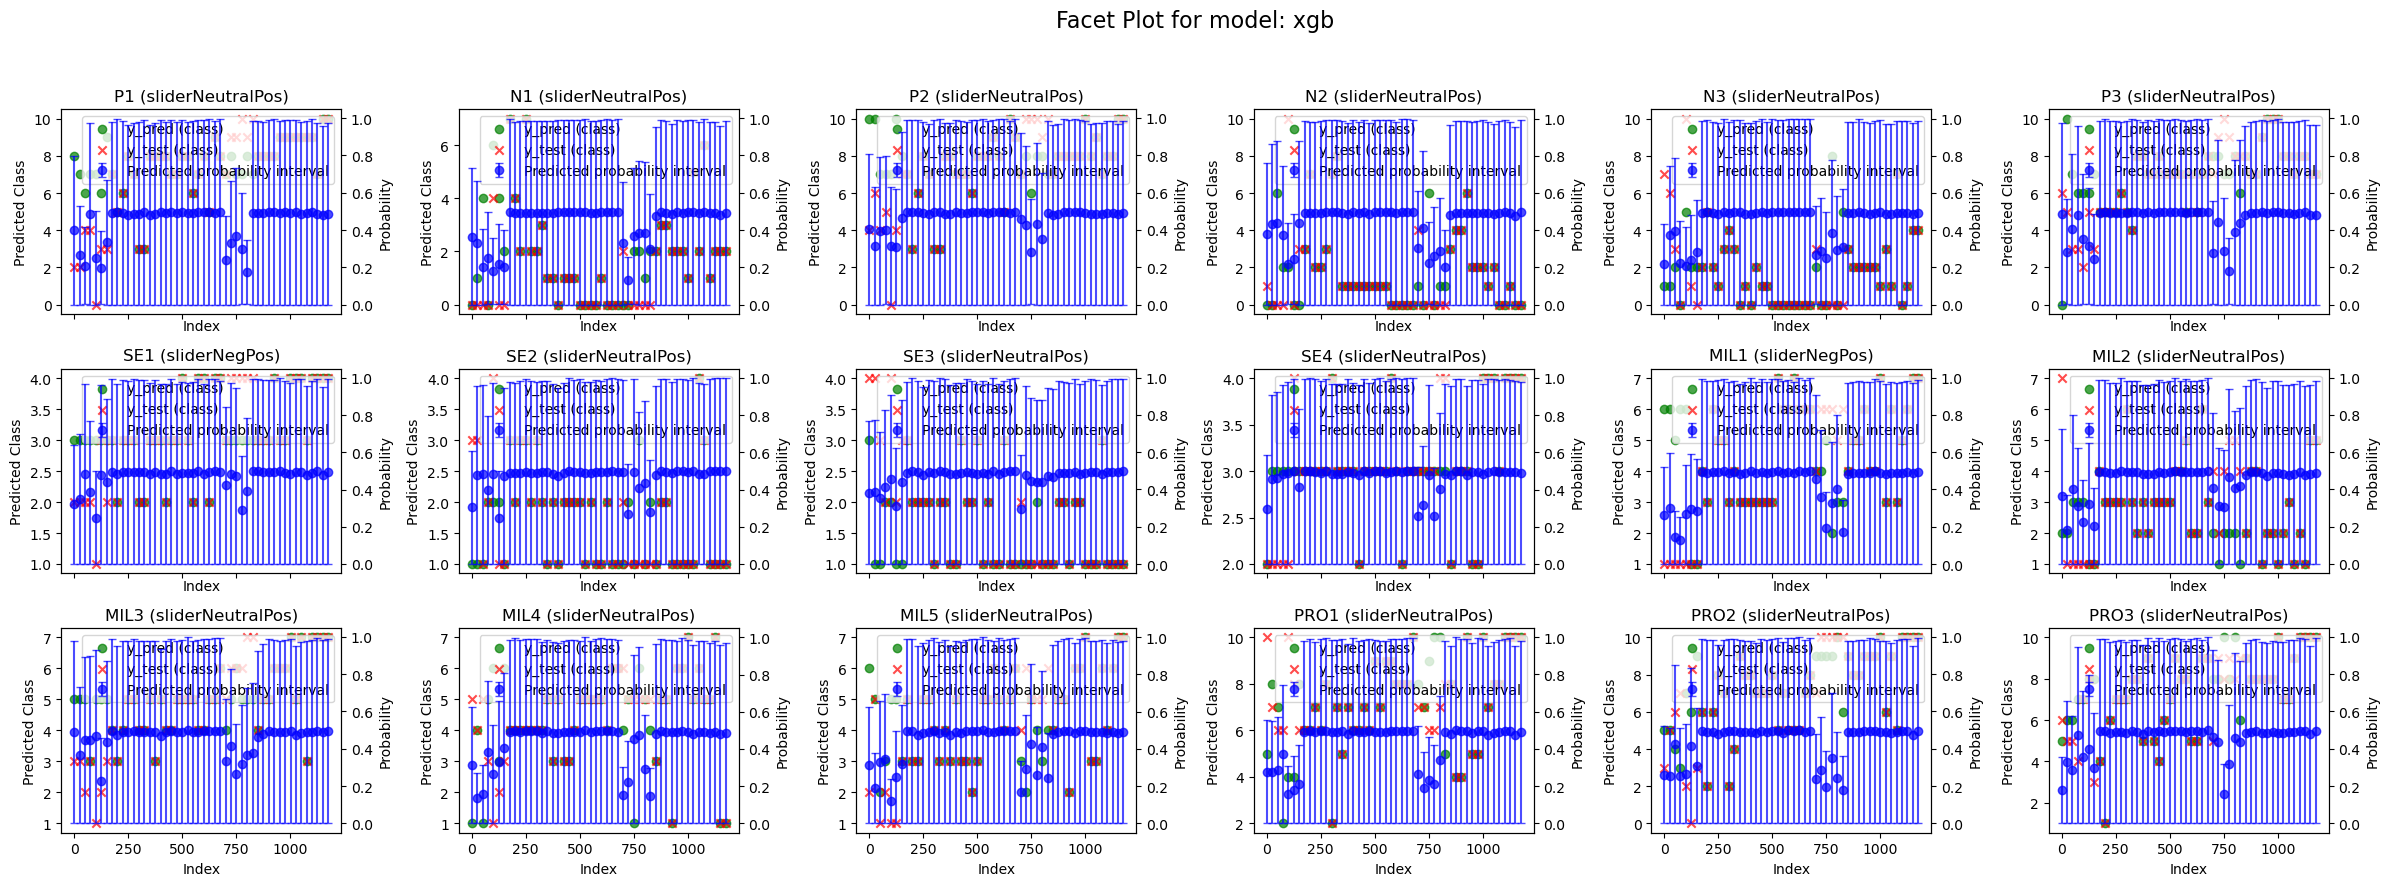

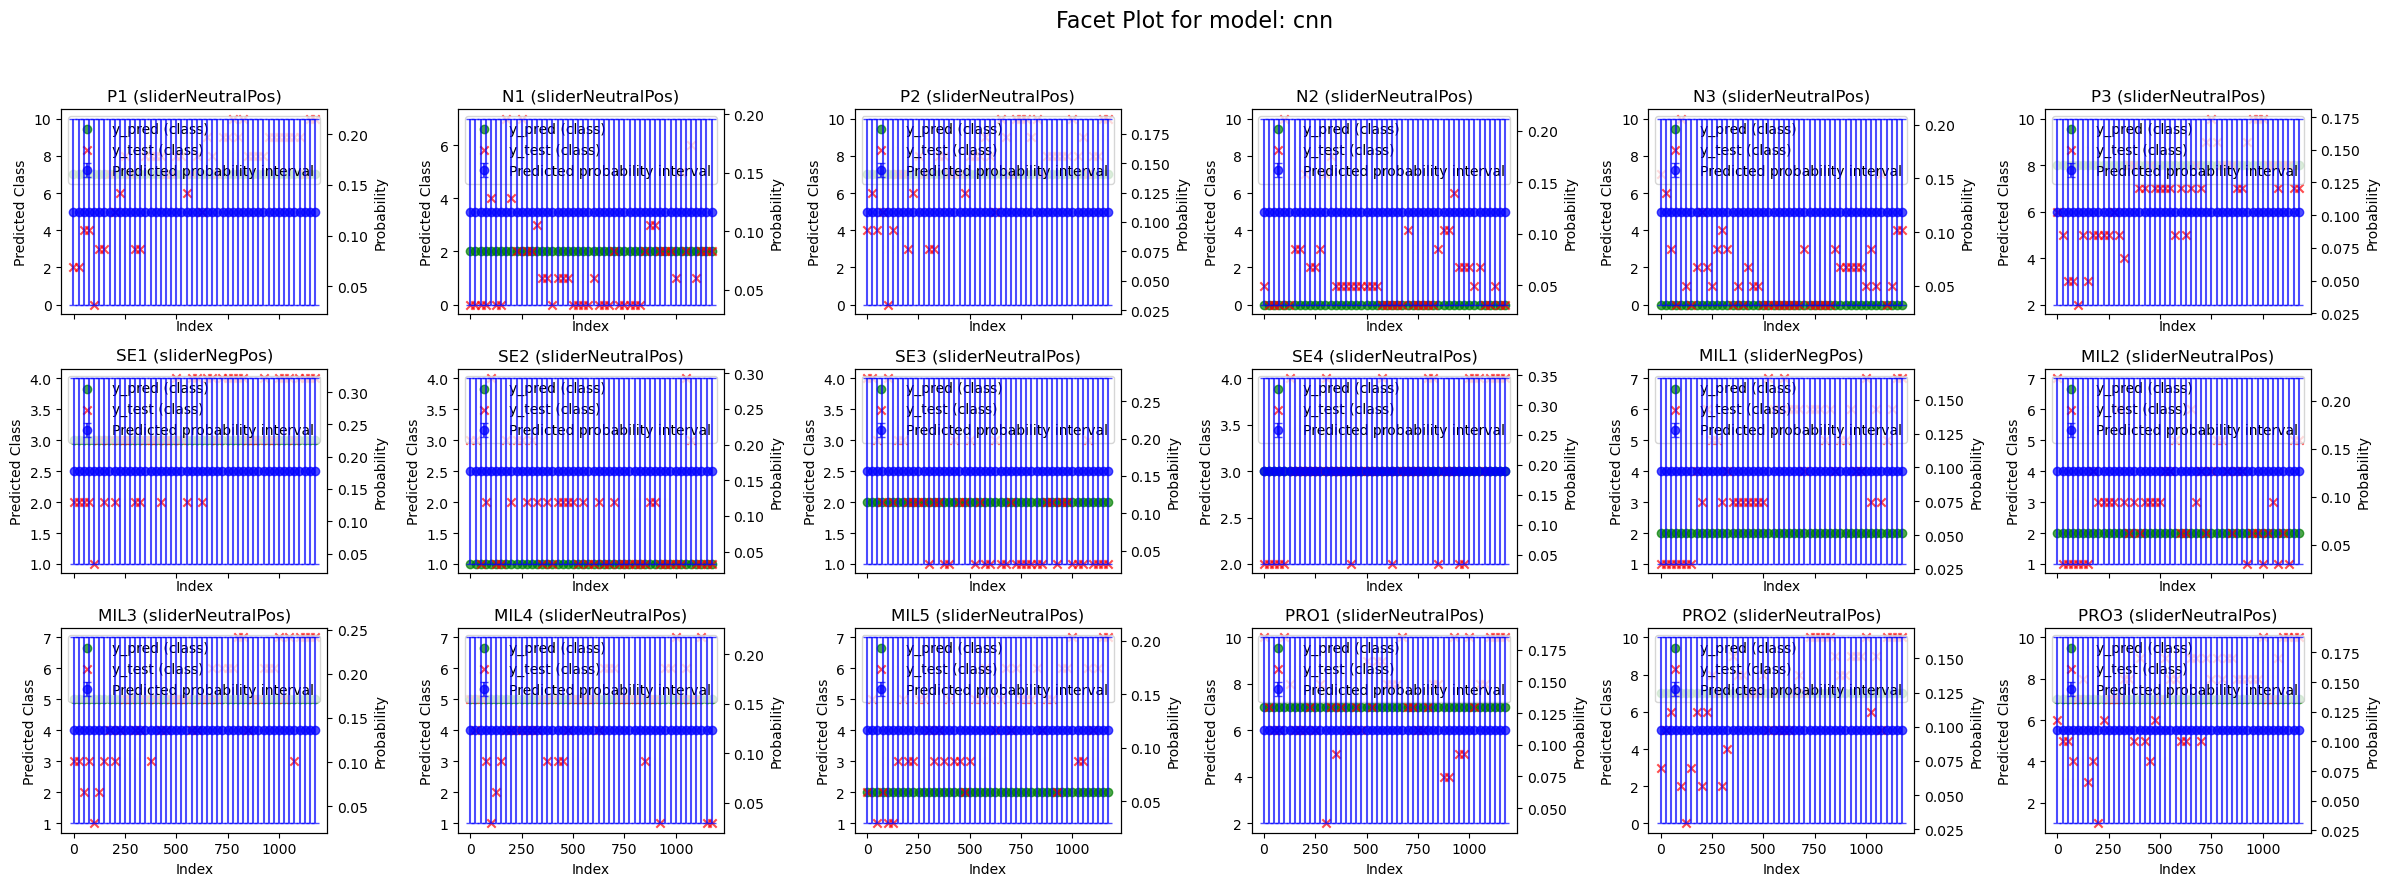

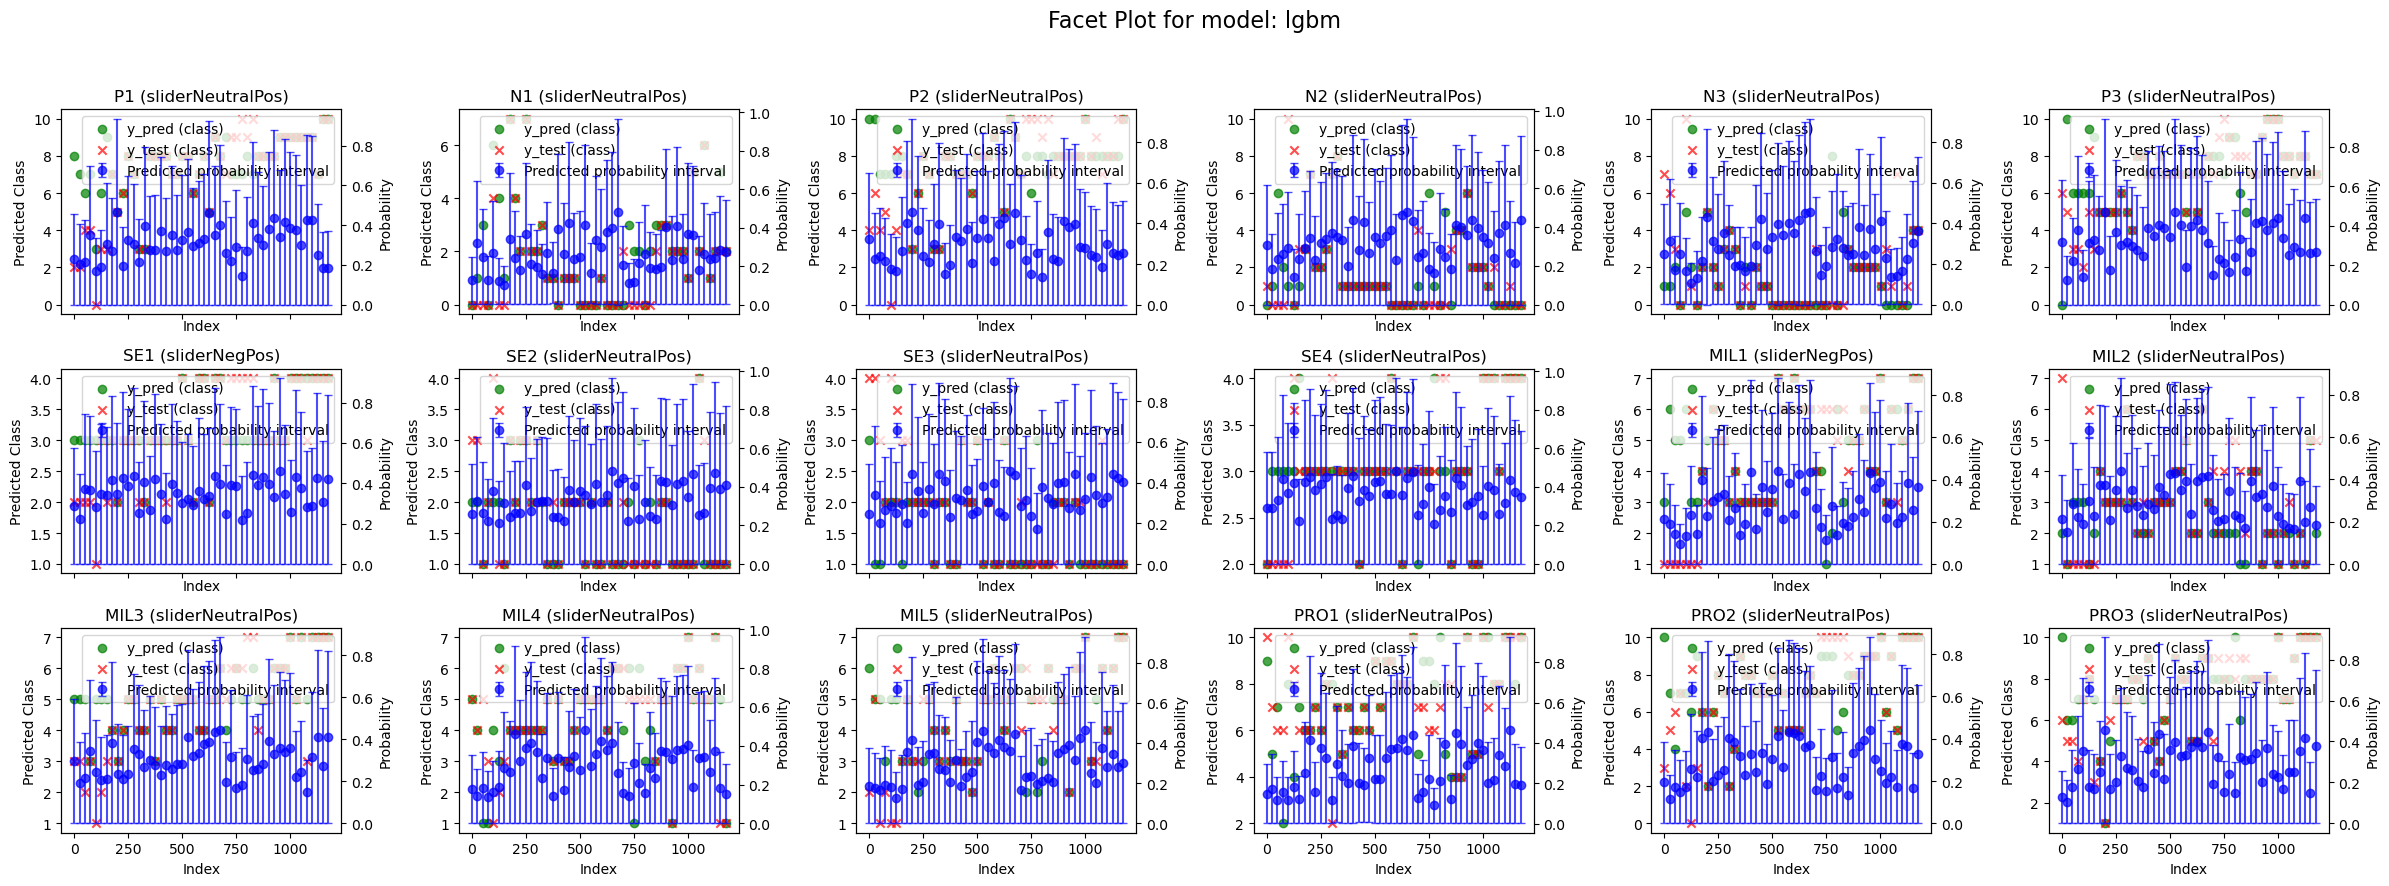

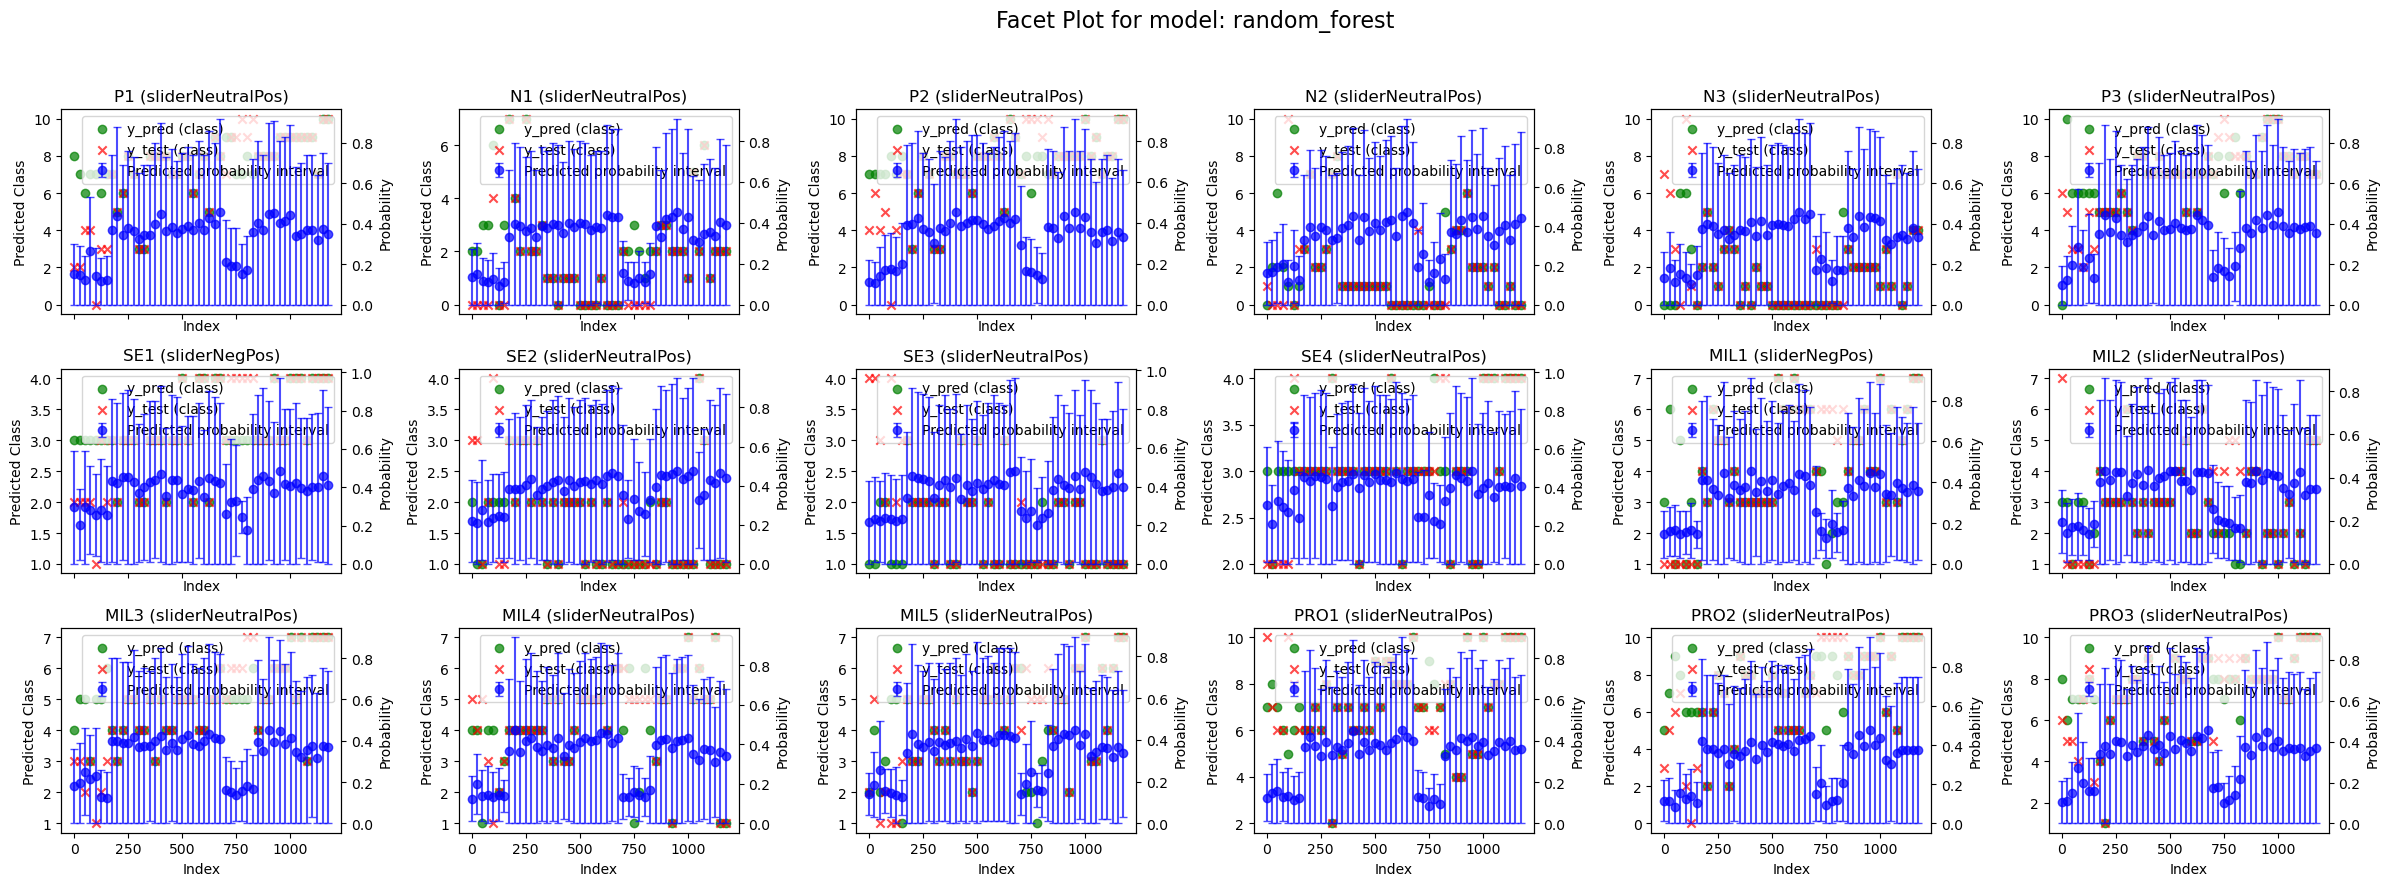

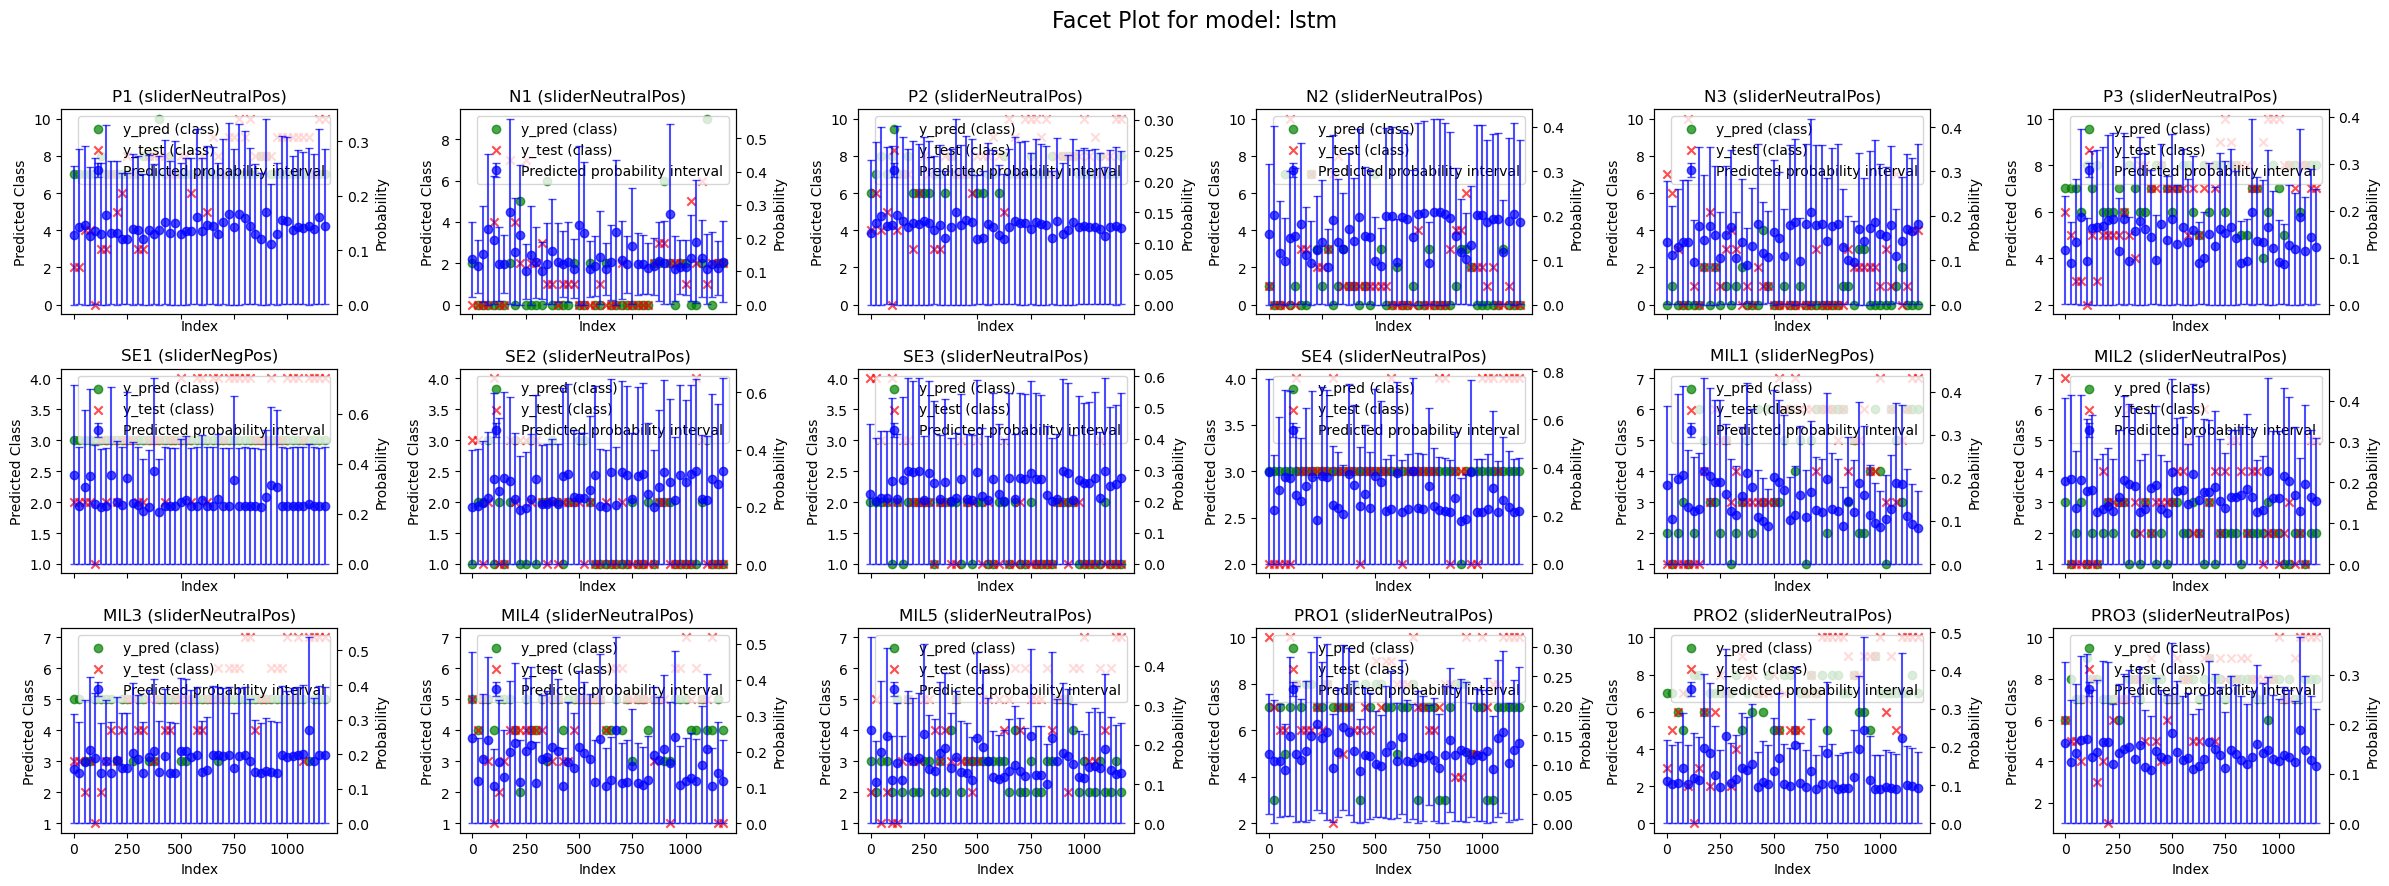

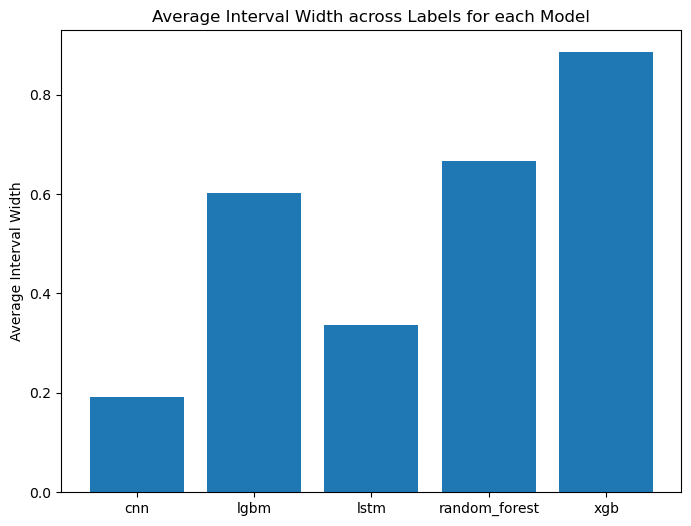

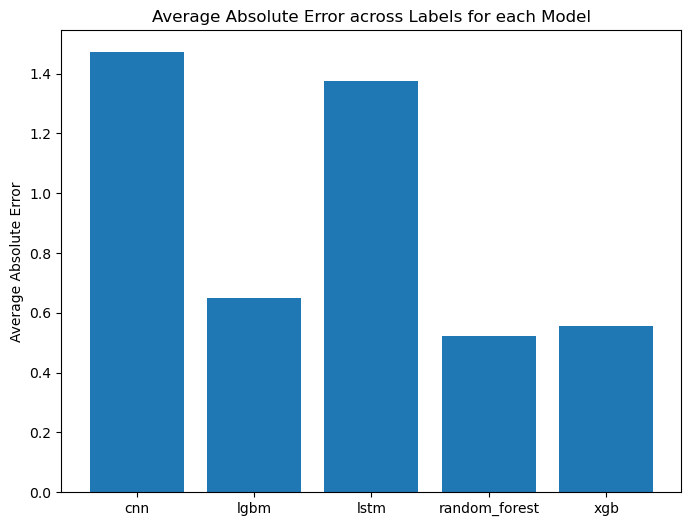

In [5]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_facet_for_model(model_type, results_dir="results_mapie", 
                         jitter_amount=0.2, sample_rate=25):
    """
    Creates a facet grid for a single model type.
    
    For each label folder:
      - The primary y-axis shows the predicted class (y_pred) and the true class (y_test).
      - If the lower bound values are very low (e.g. max < 1, indicating probability intervals),
        a secondary y-axis is created to show the probability intervals.
    
    Parameters:
      model_type: string; the model type (e.g. "xgb").
      results_dir: directory where the results CSVs are stored.
      jitter_amount: standard deviation for jitter added to the x-axis.
      sample_rate: sample every nth point from the data (1 means all points).
    """
    # Exclude hidden folders (like .ipynb_checkpoints)
    label_dirs = [d for d in os.listdir(results_dir) 
                  if os.path.isdir(os.path.join(results_dir, d)) and not d.startswith('.')]
    data_dict = {}
    for label in label_dirs:
        file_name = f"{model_type}_intervals_{label}.csv"
        file_path = os.path.join(results_dir, label, file_name)
        if os.path.exists(file_path):
            df = pd.read_csv(file_path)
            data_dict[label] = df
        else:
            print(f"File not found: {file_path}")
    
    n_labels = len(data_dict)
    if n_labels == 0:
        print("No data found for model type:", model_type)
        return
    
    n_cols = 6
    n_rows = math.ceil(n_labels / n_cols)
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 3), sharex=True, sharey=False)
    axes = axes.flatten()
    
    for ax in axes[n_labels:]:
        ax.set_visible(False)
    
    for i, (label, df) in enumerate(data_dict.items()):
        ax = axes[i]
        # Down-sample the data points.
        df_sampled = df.iloc[::sample_rate, :].copy()
        x = df_sampled["Index"].values
        # Add jitter to x values to reduce overlap.
        jitter = np.random.normal(0, jitter_amount, size=len(x))
        x_jittered = x + jitter
        
        y_pred = df_sampled["y_pred"]
        y_test = df_sampled["y_test"]
        lower = df_sampled["Lower_Bound"]
        upper = df_sampled["Upper_Bound"]
        
        # Check if the lower bounds indicate probability space.
        if lower.max() < 1:
            # Fallback mode: the intervals are probabilities.
            # Plot the class predictions on the primary y-axis.
            ax.scatter(x_jittered, y_pred, color='green', marker='o', alpha=0.7, label='y_pred (class)')
            ax.scatter(x_jittered, y_test, color='red', marker='x', alpha=0.7, label='y_test (class)')
            ax.set_ylabel("Predicted Class")
            
            # Compute a representative predicted probability (average of lower and upper).
            pred_prob = (lower + upper) / 2
            yerr_lower = pred_prob - lower
            yerr_upper = upper - pred_prob
            
            # Create a secondary y-axis for the probability intervals.
            ax2 = ax.twinx()
            ax2.errorbar(x_jittered, pred_prob, yerr=[yerr_lower, yerr_upper], fmt='o', capsize=3, 
                         color='blue', alpha=0.7, label='Predicted probability interval')
            ax2.set_ylabel("Probability")
            # Combine legends from both axes.
            h1, l1 = ax.get_legend_handles_labels()
            h2, l2 = ax2.get_legend_handles_labels()
            ax.legend(h1+h2, l1+l2, loc='upper right')
        else:
            # Normal mode: everything is on the same scale.
            yerr_lower = y_pred - lower
            yerr_upper = upper - y_pred
            yerr = [yerr_lower, yerr_upper]
            ax.errorbar(x_jittered, y_pred, yerr=yerr, fmt='o', capsize=3, alpha=0.7, label='y_pred with interval')
            ax.scatter(x_jittered, y_test, color='red', marker='x', alpha=0.7, label='y_test')
            ax.set_ylabel("Value")
            ax.legend(loc='upper right')
        
        ax.set_title(label)
        ax.set_xlabel("Index")
    
    fig.suptitle(f"Facet Plot for model: {model_type}", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()




# Example usage:
plot_facet_for_model("xgb", results_dir="results_mapie")
plot_facet_for_model("cnn", results_dir="results_mapie")
plot_facet_for_model("lgbm", results_dir="results_mapie")
plot_facet_for_model("random_forest", results_dir="results_mapie")
plot_facet_for_model("lstm", results_dir="results_mapie")
plot_summary_metrics(results_dir="results_mapie")


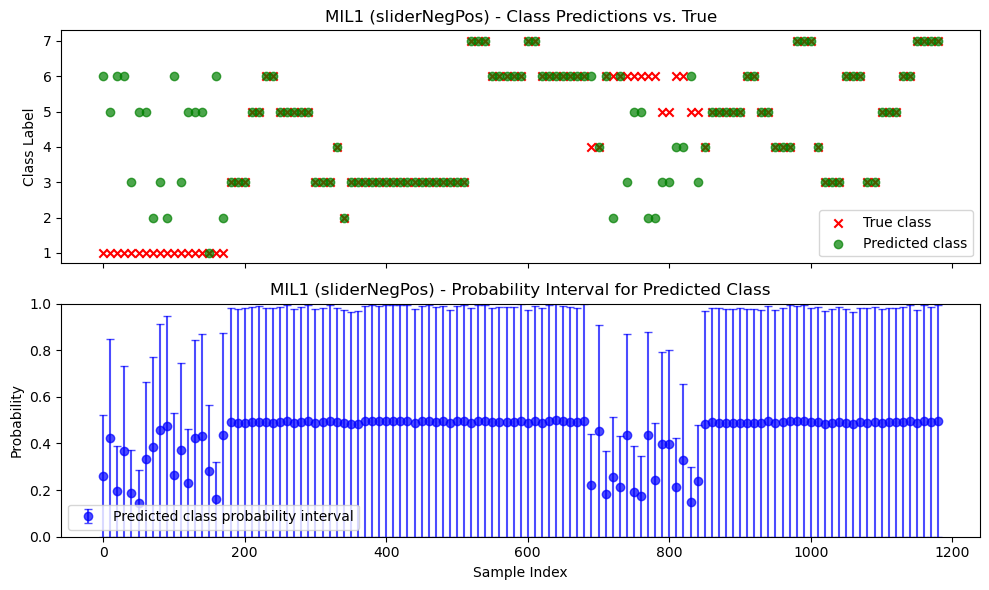

In [6]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_class_and_probability_intervals(csv_path, label_name, sample_rate=1):
    """
    Reads a MAPIE result CSV for a classification task, then creates a figure
    with two subplots:
    
    1) Discrete predicted class vs. true class (top subplot)
    2) Probability intervals for the predicted class (bottom subplot)

    Args:
        csv_path (str): Path to the CSV file (e.g. "results_mapie/label/xgb_intervals_label.csv").
        label_name (str): Name of the label, just for the figure title.
        sample_rate (int): Plot every nth point to reduce clutter (1 = all points).
    """
    if not os.path.exists(csv_path):
        print(f"File not found: {csv_path}")
        return

    df = pd.read_csv(csv_path)
    if df.empty:
        print(f"Empty file: {csv_path}")
        return

    # Optionally down-sample (every nth row).
    df_sampled = df.iloc[::sample_rate, :].copy()

    x = df_sampled["Index"].values
    y_test = df_sampled["y_test"].values
    y_pred = df_sampled["y_pred"].values
    lower = df_sampled["Lower_Bound"].values
    upper = df_sampled["Upper_Bound"].values

    # Figure with 2 subplots (stacked vertically).
    fig, (ax_class, ax_prob) = plt.subplots(
        2, 1, figsize=(10, 6), sharex=True, gridspec_kw={"height_ratios": [1, 1]}
    )

    # --- 1) Top subplot: discrete classes (predicted vs. true) ---
    ax_class.scatter(x, y_test, color='red', marker='x', label='True class')
    ax_class.scatter(x, y_pred, color='green', marker='o', alpha=0.7, label='Predicted class')
    ax_class.set_ylabel("Class Label")
    ax_class.set_title(f"{label_name} - Class Predictions vs. True")
    ax_class.legend(loc='best')

    # --- 2) Bottom subplot: probability intervals for predicted class ---
    # We'll interpret lower and upper as the confidence interval around
    # the predicted class's probability. 
    # Plot a line (or points) for the "mid" probability, plus error bars:
    mid_prob = (lower + upper) / 2.0
    error_lower = mid_prob - lower
    error_upper = upper - mid_prob

    # You could do a line or scatter. Let's do scatter with error bars:
    ax_prob.errorbar(
        x, mid_prob,
        yerr=[error_lower, error_upper],
        fmt='o', color='blue', ecolor='blue', capsize=3, alpha=0.7,
        label='Predicted class probability interval'
    )
    ax_prob.set_ylim([0, 1])  # Typically probability in [0, 1]
    ax_prob.set_ylabel("Probability")
    ax_prob.set_xlabel("Sample Index")
    ax_prob.set_title(f"{label_name} - Probability Interval for Predicted Class")
    ax_prob.legend(loc='best')

    fig.tight_layout()
    plt.show()


# --------------------------------------------------------------------
# Example usage for one label & one model:
# --------------------------------------------------------------------
# Suppose you have a file like:
#   results_mapie/MIL1 (sliderNegPos)/xgb_intervals_MIL1 (sliderNegPos).csv
# Then you might do:

csv_file = "results_mapie/MIL1 (sliderNegPos)/xgb_intervals_MIL1 (sliderNegPos).csv"
plot_class_and_probability_intervals(csv_file, label_name="MIL1 (sliderNegPos)", sample_rate=10)


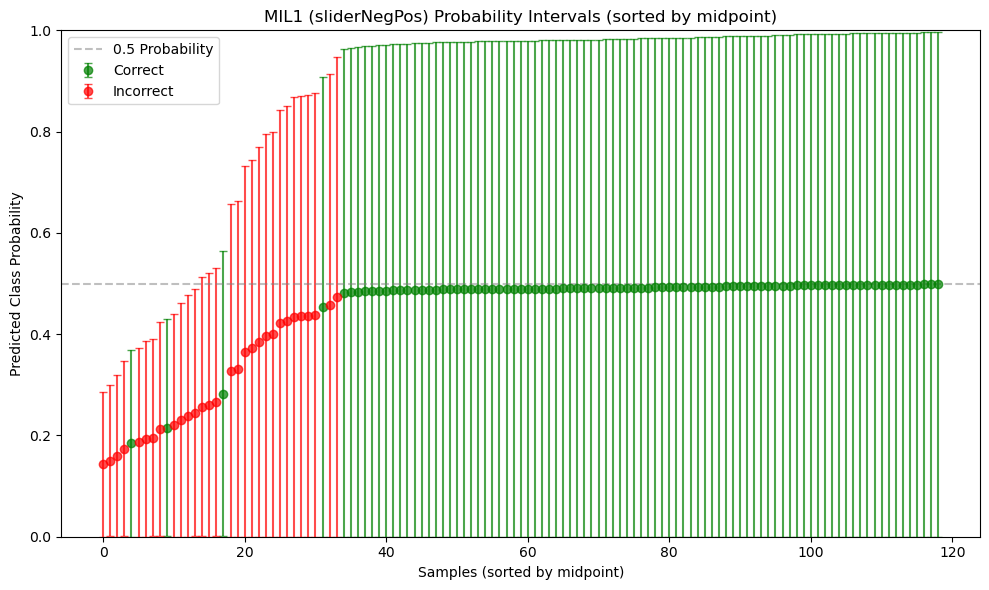

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

def plot_probability_intervals_smart(csv_path, label_name="", sample_rate=1):
    """
    Reads a MAPIE result CSV containing:
      Index, y_test, y_pred, Lower_Bound, Upper_Bound
    Assumes Lower_Bound and Upper_Bound are probabilities for the predicted class.

    Plots each row as a point at the midpoint of [Lower_Bound, Upper_Bound],
    with an error bar showing the interval width. Points are color-coded
    by whether y_pred == y_test (green for correct, red for incorrect).

    Args:
      csv_path: Path to the CSV file.
      label_name: Label for the plot title.
      sample_rate: Plot every nth row (1 = all rows).
    """
    df = pd.read_csv(csv_path)
    if df.empty:
        print(f"Empty file: {csv_path}")
        return

    # Down-sample if necessary.
    df = df.iloc[::sample_rate, :].copy()

    # Compute midpoint and error bars.
    df["mid_prob"] = 0.5 * (df["Lower_Bound"] + df["Upper_Bound"])
    df["err_lower"] = df["mid_prob"] - df["Lower_Bound"]
    df["err_upper"] = df["Upper_Bound"] - df["mid_prob"]
    df["width"] = df["Upper_Bound"] - df["Lower_Bound"]

    # Mark correctness.
    df["correct"] = (df["y_pred"] == df["y_test"])

    # Sort by midpoint.
    df_sorted = df.sort_values("mid_prob", ascending=True).reset_index(drop=True)

    # Separate into correct and incorrect groups.
    correct_df = df_sorted[df_sorted["correct"]]
    incorrect_df = df_sorted[~df_sorted["correct"]]

    # x-values: use the sorted index.
    correct_x = correct_df.index.values
    incorrect_x = incorrect_df.index.values

    plt.figure(figsize=(10, 6))
    
    # Plot correct predictions.
    plt.errorbar(
        correct_x,
        correct_df["mid_prob"],
        yerr=[
            correct_df["mid_prob"] - correct_df["Lower_Bound"],
            correct_df["Upper_Bound"] - correct_df["mid_prob"]
        ],
        fmt="o", color="green", alpha=0.7, capsize=3, label="Correct"
    )
    
    # Plot incorrect predictions.
    plt.errorbar(
        incorrect_x,
        incorrect_df["mid_prob"],
        yerr=[
            incorrect_df["mid_prob"] - incorrect_df["Lower_Bound"],
            incorrect_df["Upper_Bound"] - incorrect_df["mid_prob"]
        ],
        fmt="o", color="red", alpha=0.7, capsize=3, label="Incorrect"
    )
    
    # Add a horizontal reference line.
    plt.axhline(0.5, color="gray", linestyle="--", alpha=0.5, label="0.5 Probability")
    
    plt.xlabel("Samples (sorted by midpoint)")
    plt.ylabel("Predicted Class Probability")
    plt.title(f"{label_name} Probability Intervals (sorted by midpoint)")
    plt.ylim([0, 1])
    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.show()

# Example usage:
csv_file = "results_mapie/MIL1 (sliderNegPos)/xgb_intervals_MIL1 (sliderNegPos).csv"
plot_probability_intervals_smart(csv_file, label_name="MIL1 (sliderNegPos)", sample_rate=10)



=== Plotting for model: cnn ===


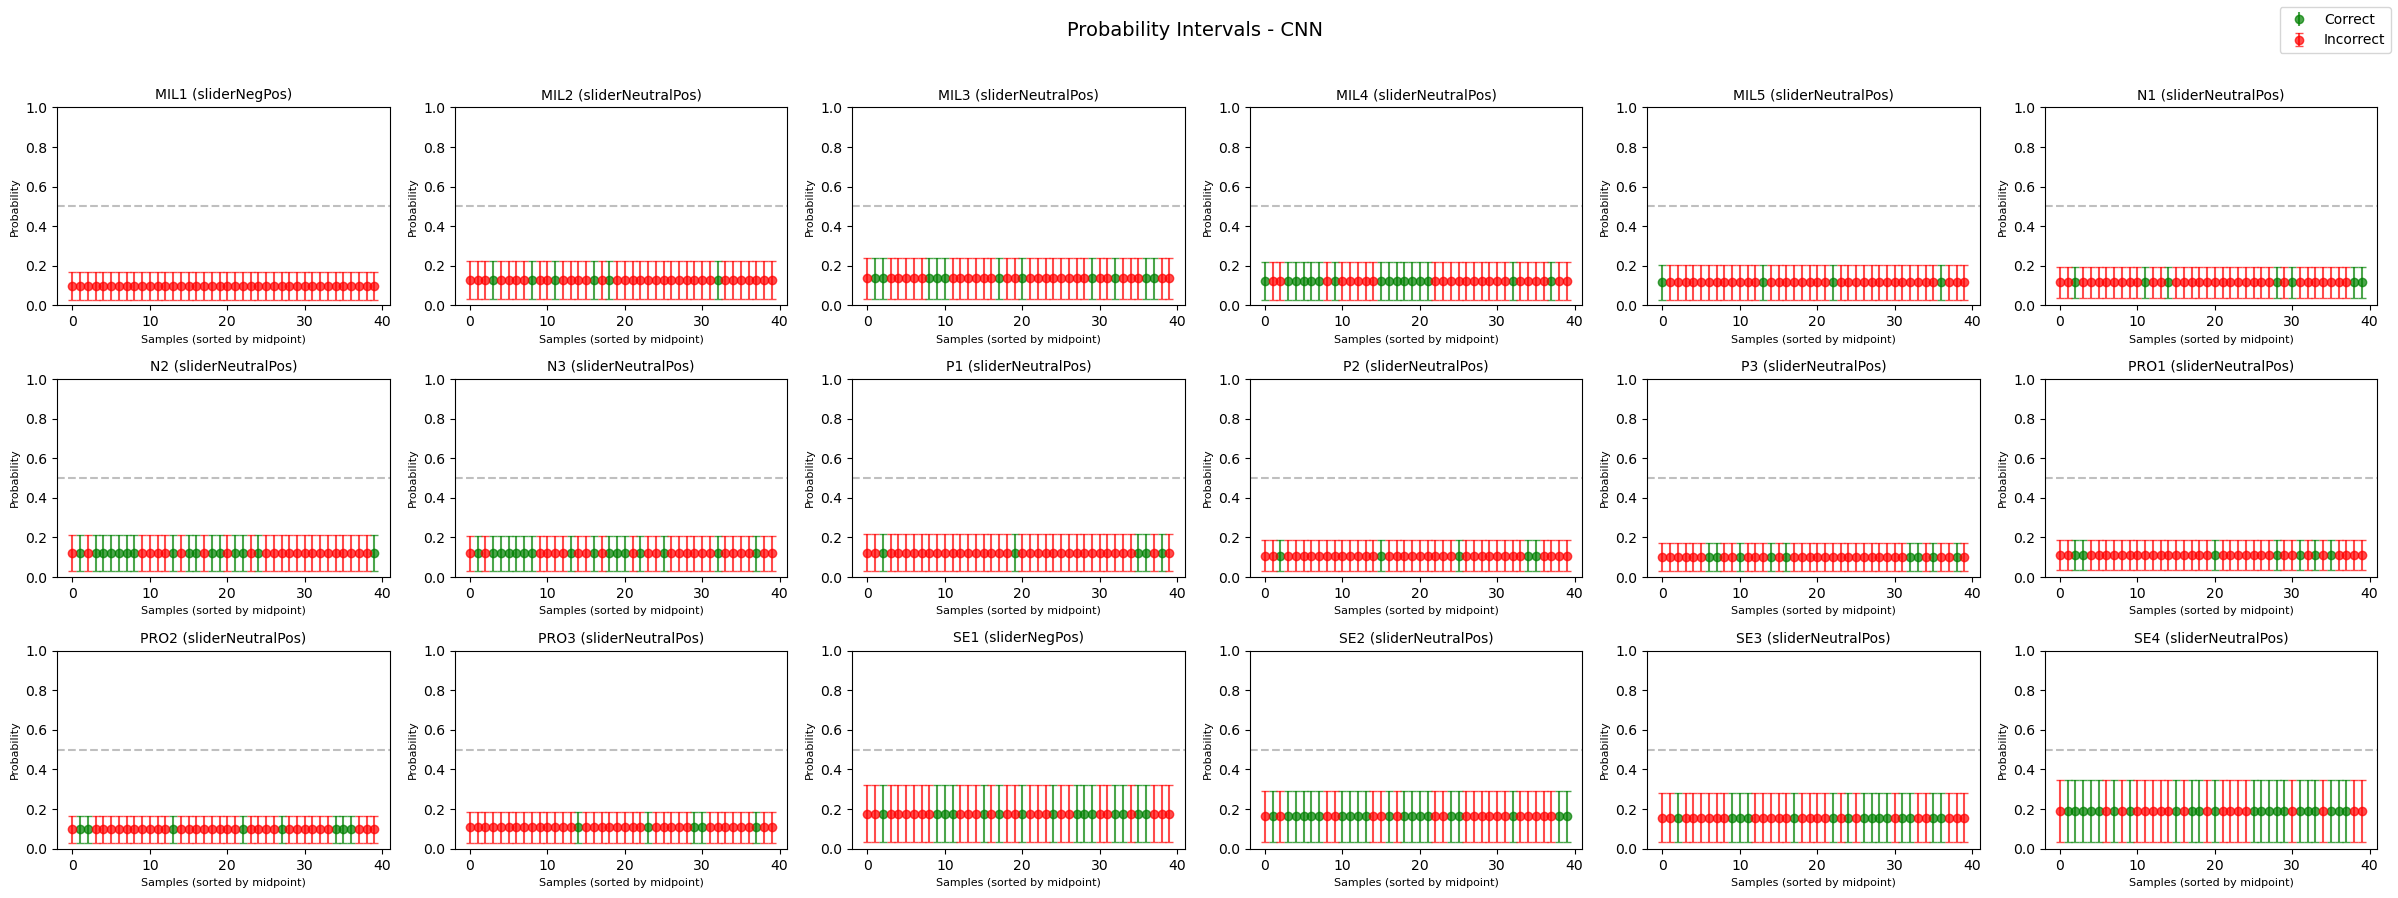


=== Plotting for model: lgbm ===


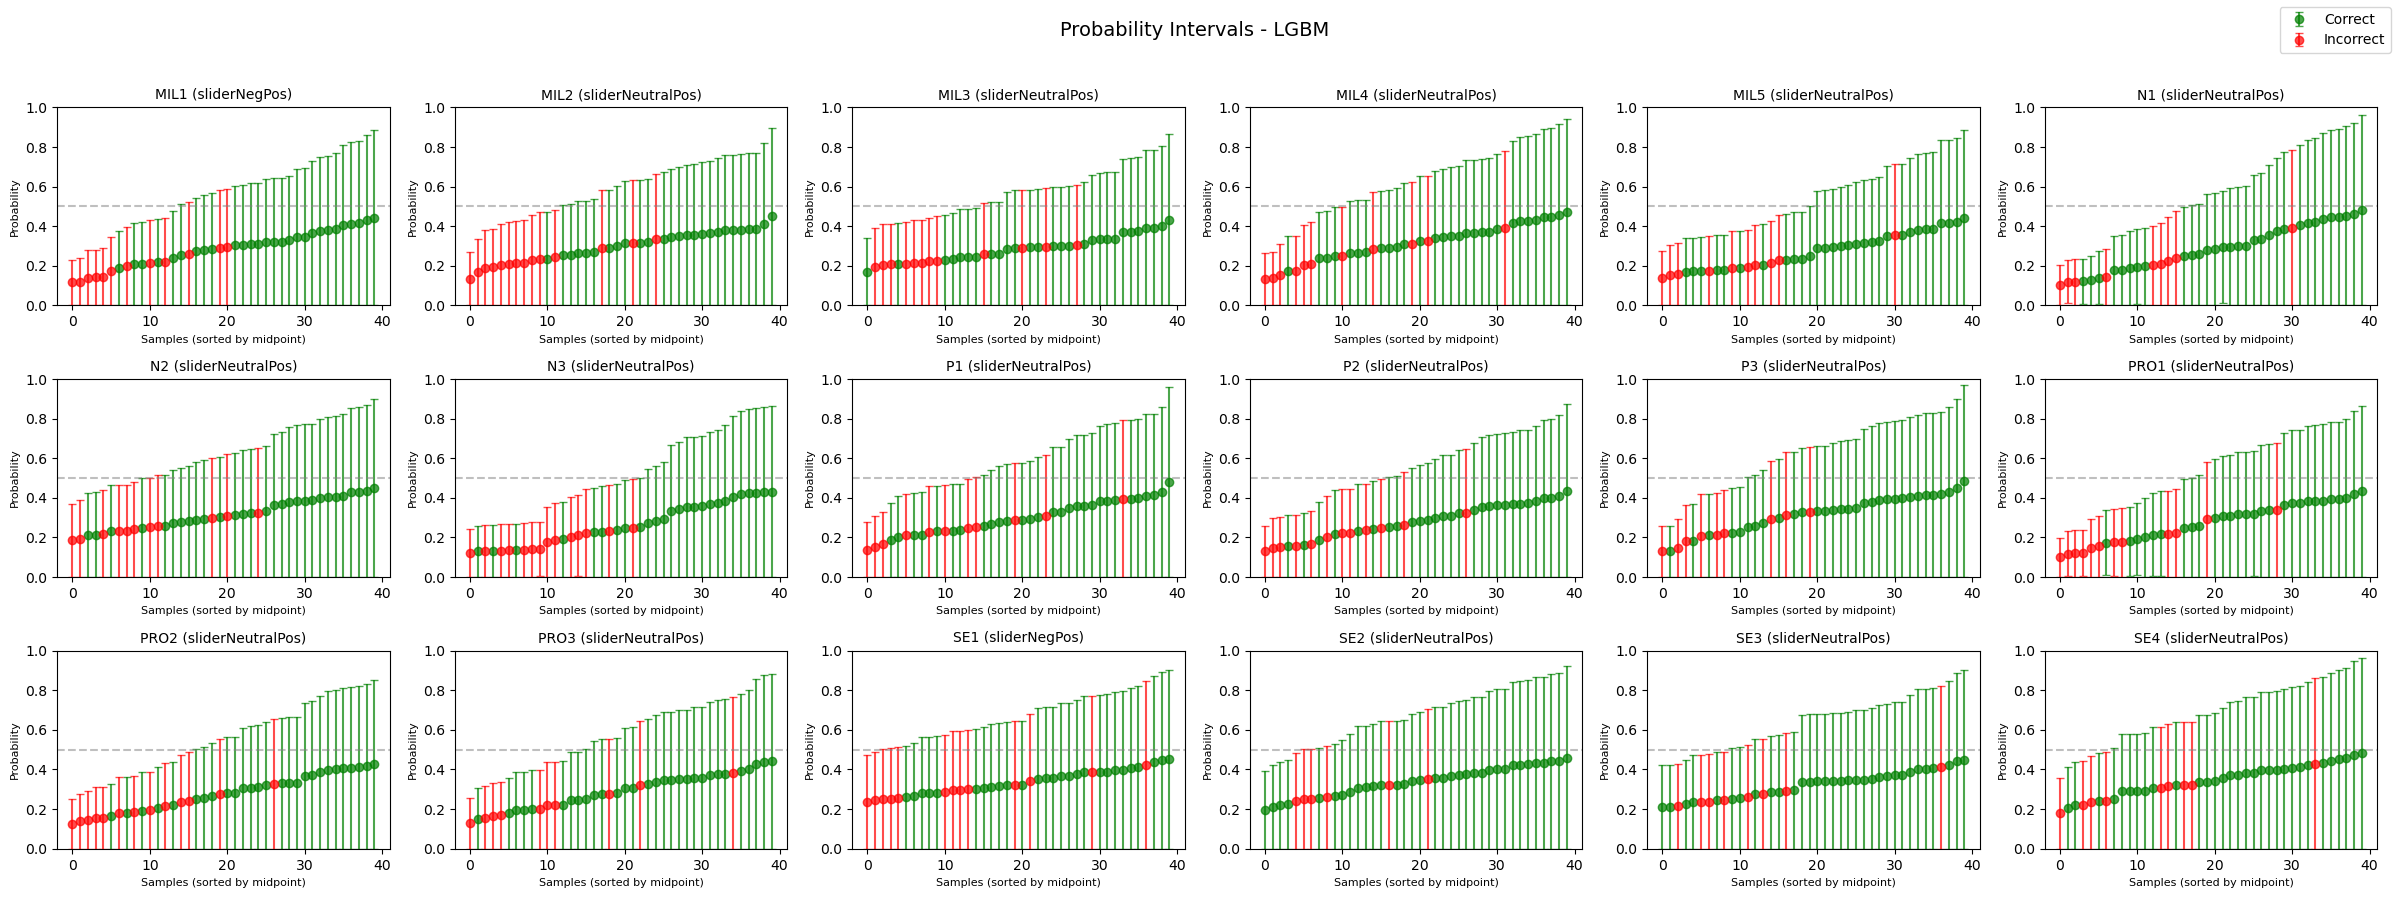


=== Plotting for model: lstm ===


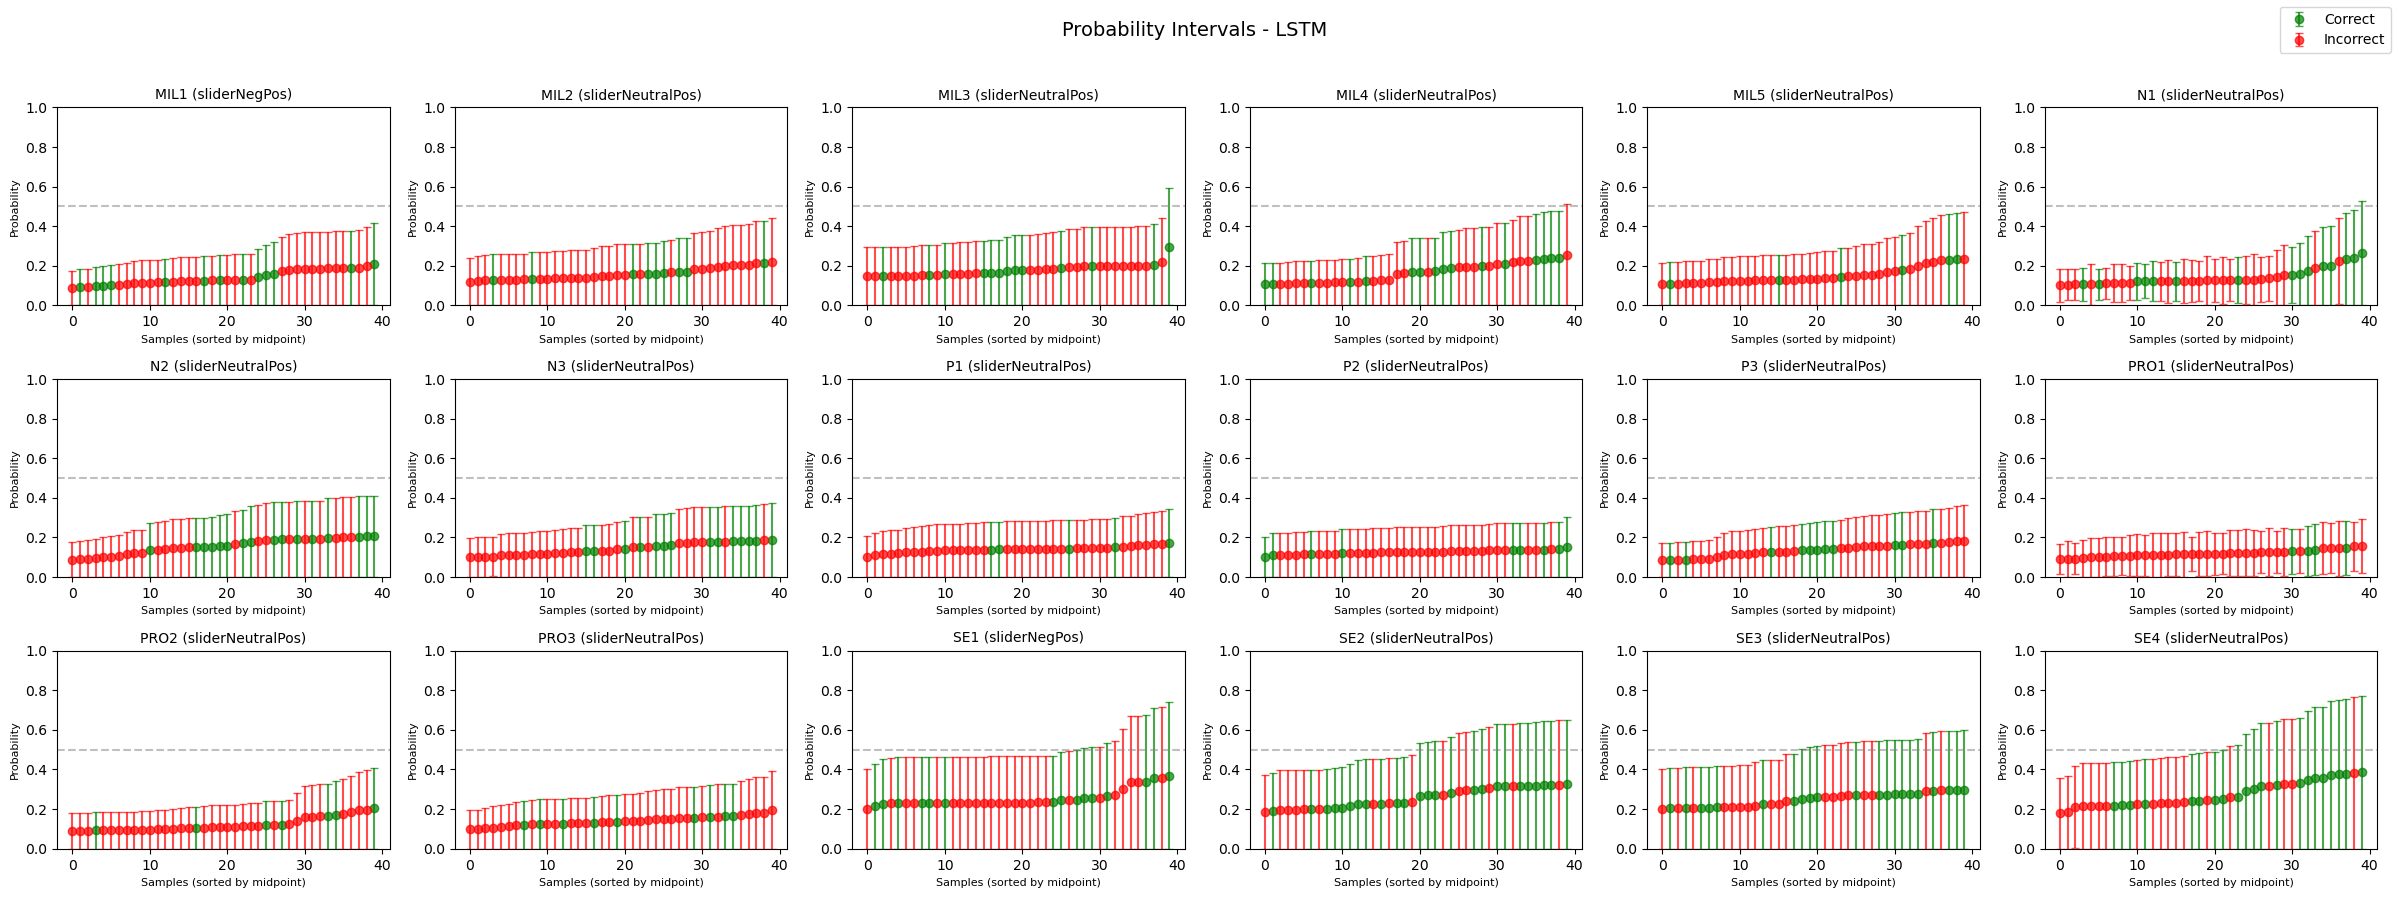


=== Plotting for model: random_forest ===


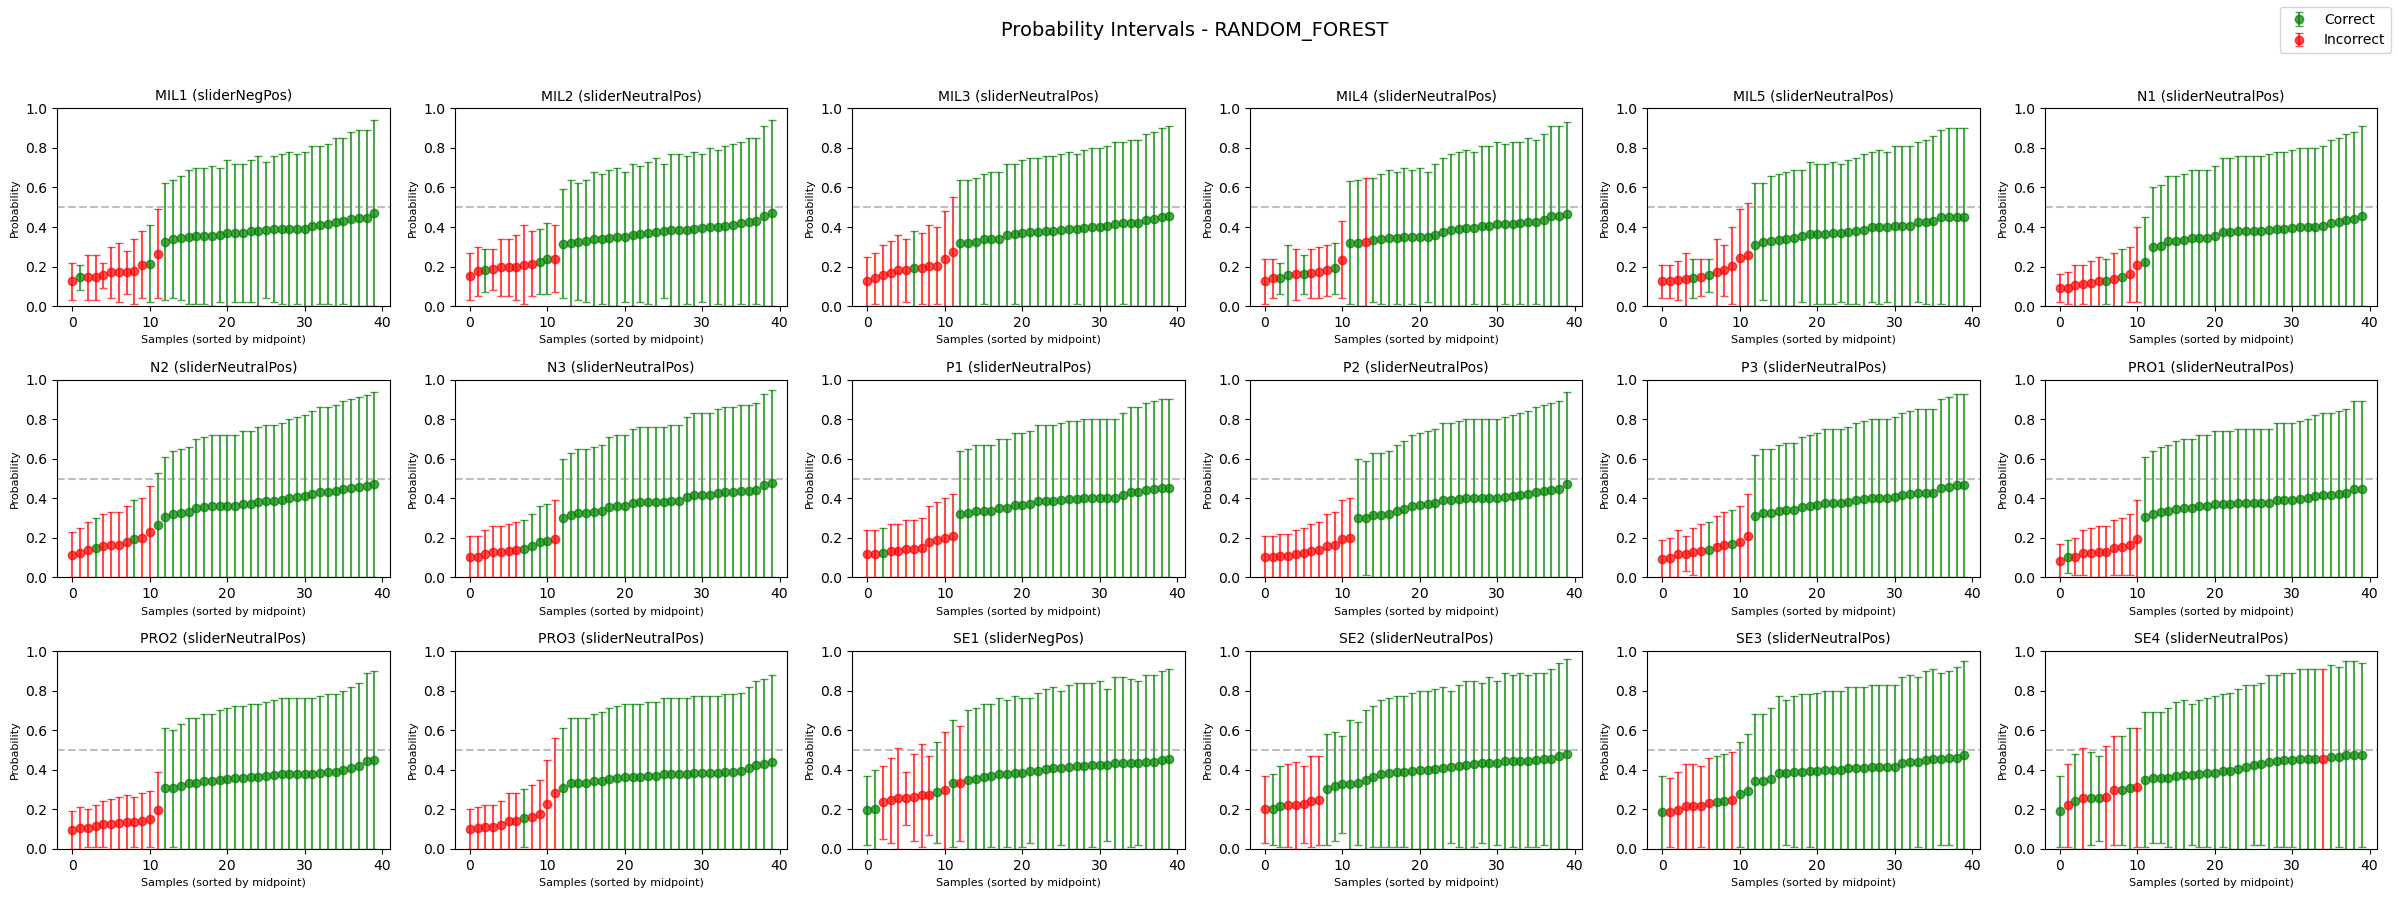


=== Plotting for model: xgb ===


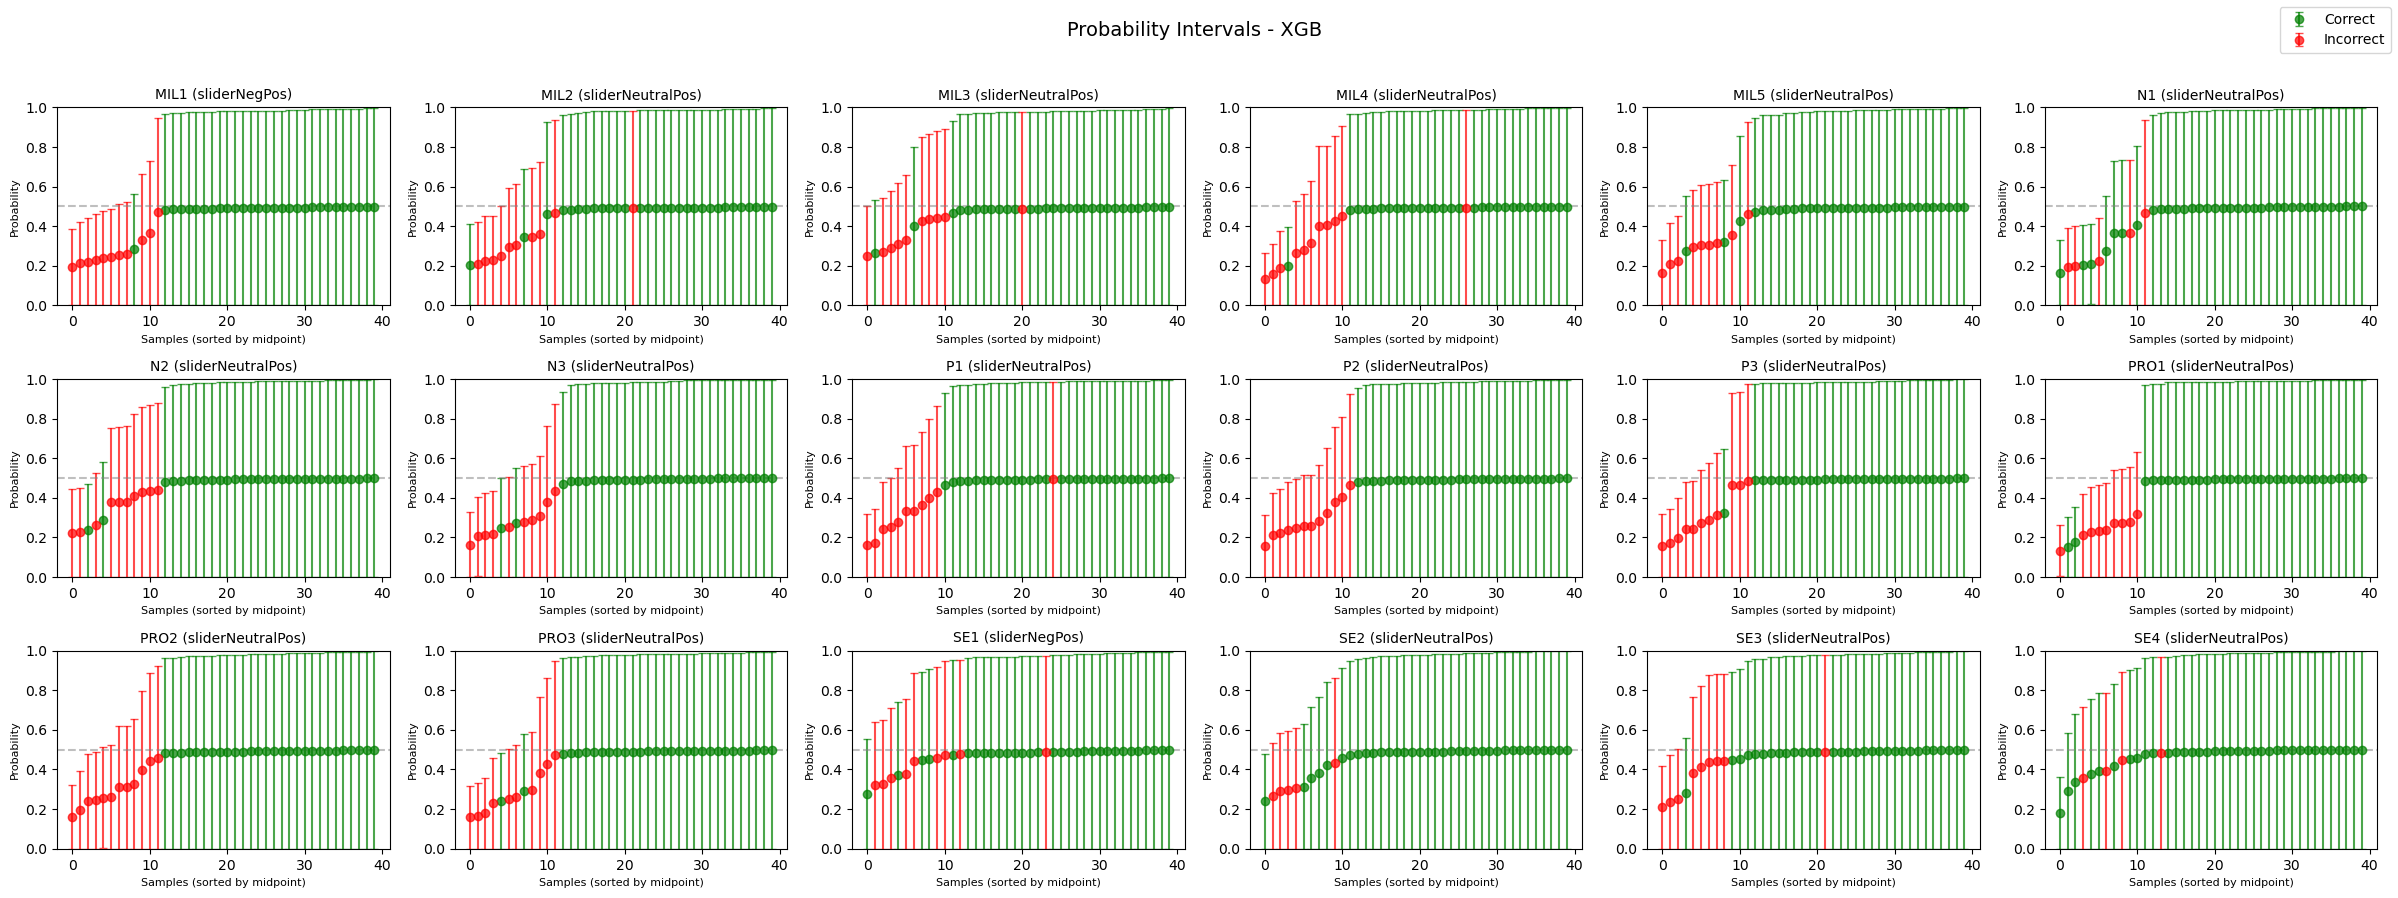

In [12]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def facet_probability_intervals_for_model(model_type, results_dir="results_mapie", sample_rate=30):
    """
    Creates a single figure with subplots for each label folder in `results_mapie`.
    Each subplot shows the probability interval (Lower_Bound, Upper_Bound) for the
    predicted class, color-coded by correctness (green=correct, red=incorrect).

    Args:
      model_type (str): one of ["cnn", "lgbm", "lstm", "random_forest", "xgb"].
      results_dir (str): path to the directory containing label subfolders.
      sample_rate (int): downsample factor (1=plot all points).
    """
    # 1) Collect label folders (excluding hidden like .ipynb_checkpoints).
    label_dirs = [
        d for d in os.listdir(results_dir)
        if os.path.isdir(os.path.join(results_dir, d)) and not d.startswith(".")
    ]
    label_dirs.sort()  # optional: sort them alphabetically

    n_labels = len(label_dirs)
    if n_labels == 0:
        print(f"No label folders found in {results_dir}.")
        return

    # 2) Create a figure with enough subplots to hold all labels
    #    For 18 labels, 3 rows x 6 cols or 6 rows x 3 cols both work.
    n_cols = 6
    n_rows = math.ceil(n_labels / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols,
                             figsize=(n_cols * 4, n_rows * 3),
                             sharex=False, sharey=False)
    axes = axes.flatten()

    # We'll keep track of how many subplots we actually fill
    subplot_idx = 0

    for label_dir in label_dirs:
        # 3) Construct the CSV filename for this model+label
        csv_filename = f"{model_type}_intervals_{label_dir}.csv"
        csv_path = os.path.join(results_dir, label_dir, csv_filename)

        if not os.path.exists(csv_path):
            print(f"[SKIP] {csv_path} not found.")
            continue

        # 4) Read the CSV
        df = pd.read_csv(csv_path)
        if df.empty:
            print(f"[SKIP] {csv_path} is empty.")
            continue

        # 5) Downsample if needed
        df = df.iloc[::sample_rate].copy()

        # 6) Compute midpoint and error bars
        df["mid_prob"] = 0.5 * (df["Lower_Bound"] + df["Upper_Bound"])
        df["err_lower"] = df["mid_prob"] - df["Lower_Bound"]
        df["err_upper"] = df["Upper_Bound"] - df["mid_prob"]
        # Mark correctness
        df["correct"] = (df["y_pred"] == df["y_test"])

        # Sort by midpoint so we move from low to high
        df_sorted = df.sort_values("mid_prob", ascending=True).reset_index(drop=True)

        # Split into correct vs. incorrect
        correct_df = df_sorted[df_sorted["correct"]]
        incorrect_df = df_sorted[~df_sorted["correct"]]

        # Prepare x-values for each group
        correct_x = correct_df.index.values
        incorrect_x = incorrect_df.index.values

        ax = axes[subplot_idx]

        # Plot correct
        ax.errorbar(
            correct_x,
            correct_df["mid_prob"],
            yerr=[
                correct_df["mid_prob"] - correct_df["Lower_Bound"],
                correct_df["Upper_Bound"] - correct_df["mid_prob"]
            ],
            fmt="o", color="green", alpha=0.7, capsize=3, label="Correct"
        )

        # Plot incorrect
        ax.errorbar(
            incorrect_x,
            incorrect_df["mid_prob"],
            yerr=[
                incorrect_df["mid_prob"] - incorrect_df["Lower_Bound"],
                incorrect_df["Upper_Bound"] - incorrect_df["mid_prob"]
            ],
            fmt="o", color="red", alpha=0.7, capsize=3, label="Incorrect"
        )

        # Optional horizontal reference line at 0.5
        ax.axhline(0.5, color="gray", linestyle="--", alpha=0.5)

        ax.set_title(label_dir, fontsize=10)
        ax.set_xlabel("Samples (sorted by midpoint)", fontsize=8)
        ax.set_ylabel("Probability", fontsize=8)
        ax.set_ylim([0, 1])  # if we know intervals are in [0,1]

        subplot_idx += 1

    # Hide any unused subplots
    for i in range(subplot_idx, n_rows * n_cols):
        axes[i].set_visible(False)

    # Create an overall legend (one time) - we can use the first subplot's handles
    handles, labels_ = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels_, loc="upper right")

    fig.suptitle(f"Probability Intervals - {model_type.upper()}", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

def plot_all_models_facet(results_dir="results_mapie", sample_rate=30):
    """
    Calls `facet_probability_intervals_for_model` for each of the 5 model types.
    This produces 5 separate figures, each with subplots for all label folders.
    """
    model_types = ["cnn", "lgbm", "lstm", "random_forest", "xgb"]
    for mtype in model_types:
        print(f"\n=== Plotting for model: {mtype} ===")
        facet_probability_intervals_for_model(mtype, results_dir, sample_rate)


# Example usage:
# This will generate 5 figures (one per model type),
# each figure containing up to 18 subplots (one per label folder).
plot_all_models_facet(results_dir="results_mapie", sample_rate=30)
